# CS155 MiniProject 1 — Colab Demo

This notebook:
- clones our team repo
- installs dependencies
- loads data (`train.csv`, `test.csv`, `sample_submission.csv`)
- runs EDA + several visualizations
- runs a small hyperparameter sweep (parameter curve)
- trains the best model and writes `submission.csv`

**Repo:** `git@github.com:NataliaZhang/SongsClassifier.git`


## (0) Clone repo

In [6]:
# %cd ..  # run this only if you have already had this folder
# !rm -rf SongsClassifier

In [3]:
!git clone https://github.com/NataliaZhang/SongsClassifier.git
%cd SongsClassifier
!git status
!git checkout nataz

Cloning into 'SongsClassifier'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 161 (delta 78), reused 127 (delta 49), pack-reused 0 (from 0)
Receiving objects: 100% (161/161), 1.77 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/content/SongsClassifier
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Branch 'nataz' set up to track remote branch 'nataz' from 'origin'.
Switched to a new branch 'nataz'


## (1) Install dependencies

In [24]:
import os, sys

!pip -q install numpy pandas scikit-learn xgboost matplotlib catboost

# Make sure we can import src/
sys.path.append(os.getcwd())
print("cwd:", os.getcwd())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
cwd: /content/SongsClassifier


## (2) Download Dataset

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import Paths, TARGET_COL
from src.data import load_train_test, load_sample_submission, _read_csv

paths = Paths()
X, y, X_test = load_train_test(paths)
sub = load_sample_submission(paths)

print("X:", X.shape)
print("y:", y.shape, "pos_rate=", float(np.mean(y)))
print("X_test:", X_test.shape)
print("sample_submission:", sub.shape, sub.columns.tolist())

X.head()

X: (3864, 17)
y: (3864,) pos_rate= 0.3517080745341615
X_test: (863, 17)
sample_submission: (863, 2) ['ID', 'Popularity_Type']


,time_signature,speechiness,danceability,duration_ms,energy,mode,type,instrumentalness,valence,key,tempo,loudness,acousticness,liveness,track_album_release_date_year,track_album_release_date_month,track_album_release_date_day
0,4.0,0.2040,0.882,140733.0,0.764,1.0,audio_features,0.000000,0.886,11.0,140.113,-5.241,0.359000,0.1190,2024.0,5.0,23.0
1,4.0,0.1590,0.779,246960.0,0.640,1.0,audio_features,0.000766,0.499,7.0,99.017,-8.415,0.000155,0.1010,2005.0,8.0,29.0
2,4.0,0.2230,0.770,189707.0,0.597,1.0,audio_features,0.000000,0.875,1.0,170.022,-4.901,0.530000,0.2390,2024.0,6.0,21.0
3,5.0,0.3210,0.573,172296.0,0.693,1.0,audio_features,0.004240,0.837,6.0,150.850,-6.220,0.609000,0.1960,2024.0,11.0,8.0
4,4.0,0.0315,0.714,274488.0,0.720,1.0,audio_features,0.000000,0.696,6.0,113.015,-6.751,0.092200,0.0742,2020.0,12.0,24.0


## (3) Quick EDA + Visualizations

### 3.1 Label distribution

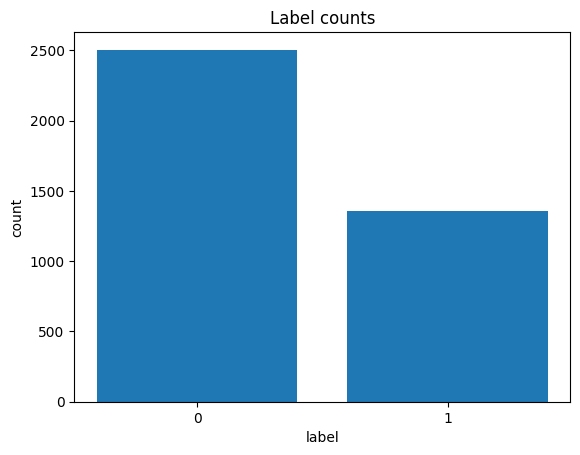

counts:
 Popularity_Type
0    2505
1    1359
Name: count, dtype: int64
positive rate: 0.3517080745341615


In [6]:
counts = pd.Series(y).value_counts().sort_index()
plt.figure()
plt.bar([str(i) for i in counts.index], counts.values)
plt.title("Label counts")
plt.xlabel("label")
plt.ylabel("count")
plt.show()

print("counts:\n", counts)
print("positive rate:", float(np.mean(y)))

### 3.2 Missingness (top 20)
Missingness measures the fraction of rows where a feature is missing (NaN).
It tells us how complete each feature is.
From the plot below, we see there is small missingness in the dataset, so we don't need to worry too much about that.

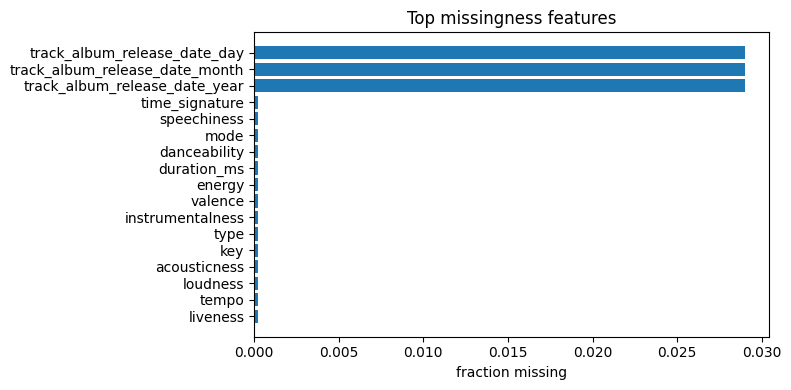

In [7]:
na_frac = X.isna().mean().sort_values(ascending=False)
top = na_frac.head(20)

plt.figure(figsize=(8,4))
plt.barh(top.index[::-1], top.values[::-1])
plt.title("Top missingness features")
plt.xlabel("fraction missing")
plt.tight_layout()
plt.show()

### 3.3 Numeric feature histograms

The histograms below summarize the marginal distributions of all the features in the dataset, which should be helpful to understand the structural patterns of the dataset.

# numeric cols: 16


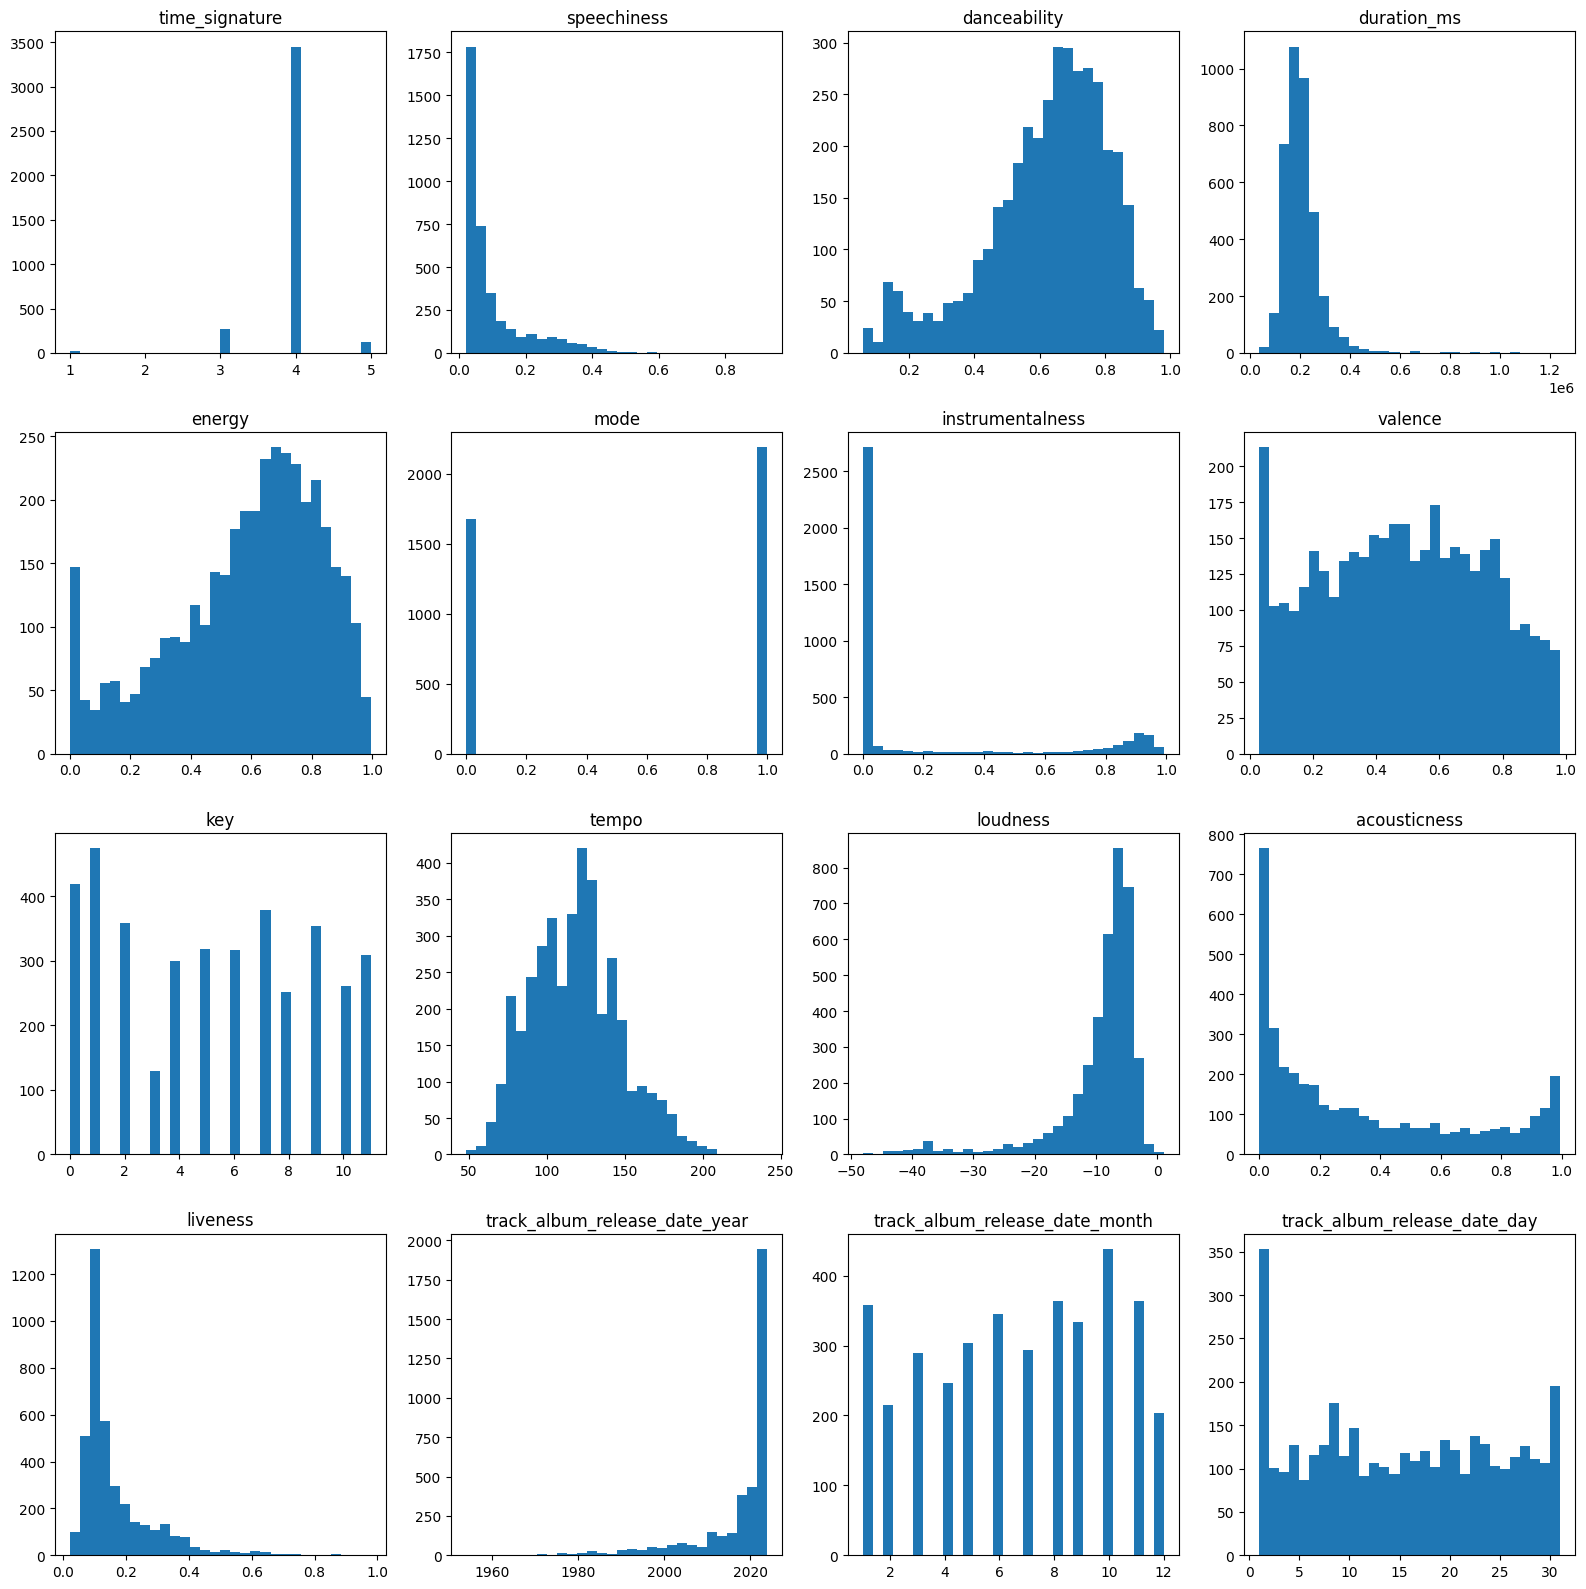

In [12]:
# 3.3 Numeric feature histograms
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
print("# numeric cols:", len(num_cols))

show_cols = num_cols
n = len(show_cols)
rows = (n + 3) // 4
plt.figure(figsize=(16, 4*rows))
for i, c in enumerate(show_cols, 1):
    plt.subplot(rows, 4, i)
    s = X[c].dropna()
    plt.hist(s.values, bins=30)
    plt.title(c)
plt.tight_layout()
plt.show()

Here is our key observations.
- Bounded audio features (e.g., danceability, energy, valence, speechiness, acousticness, instrumentalness, liveness) are mostly constrained to [0,1], but exhibit strong skewness.
Tree-based models can naturally handle non-Gaussian and asymmetric features without transformation.
- Tempo and loudness have non-symmetric distributions:
tempo clusters around 90-140 BPM with heavy tails, and loudness is tightly concentrated near -10 dB, with a long left tail.
These features may benefit from regularization, but may not require scaling for gradient-boosted trees.
- Discrete numeric features:
key (0-11) and time_signature (~4) have discrete spikes rather than continuous distributions,
and mode is binary and moderately imbalanced.
Tree-based models can exploit such discrete splits directly.
- Temporal metadata:
track_album_release_date_year shows a strong concentration in recent years, reflecting dataset bias,
while month and day are roughly uniform but still contain seasonal structure.
And duration_ms has a long tail of very long tracks, suggesting potential outliers.

Implications for modeling:
- The diversity of skewed, bounded, and discrete numeric features strongly favors XGBoost over linear models.
- No strong normalization is required.
- Regularization and depth control should be used to preventing overfitting.
- Features with heavy mass near zero (e.g., instrumentalness) may carry signal through threshold-based splits rather than linear effects.

Overall, this supports our choice of XGBoost with regularization rather than aggressive feature scaling or transformations.

# numeric cols: 16


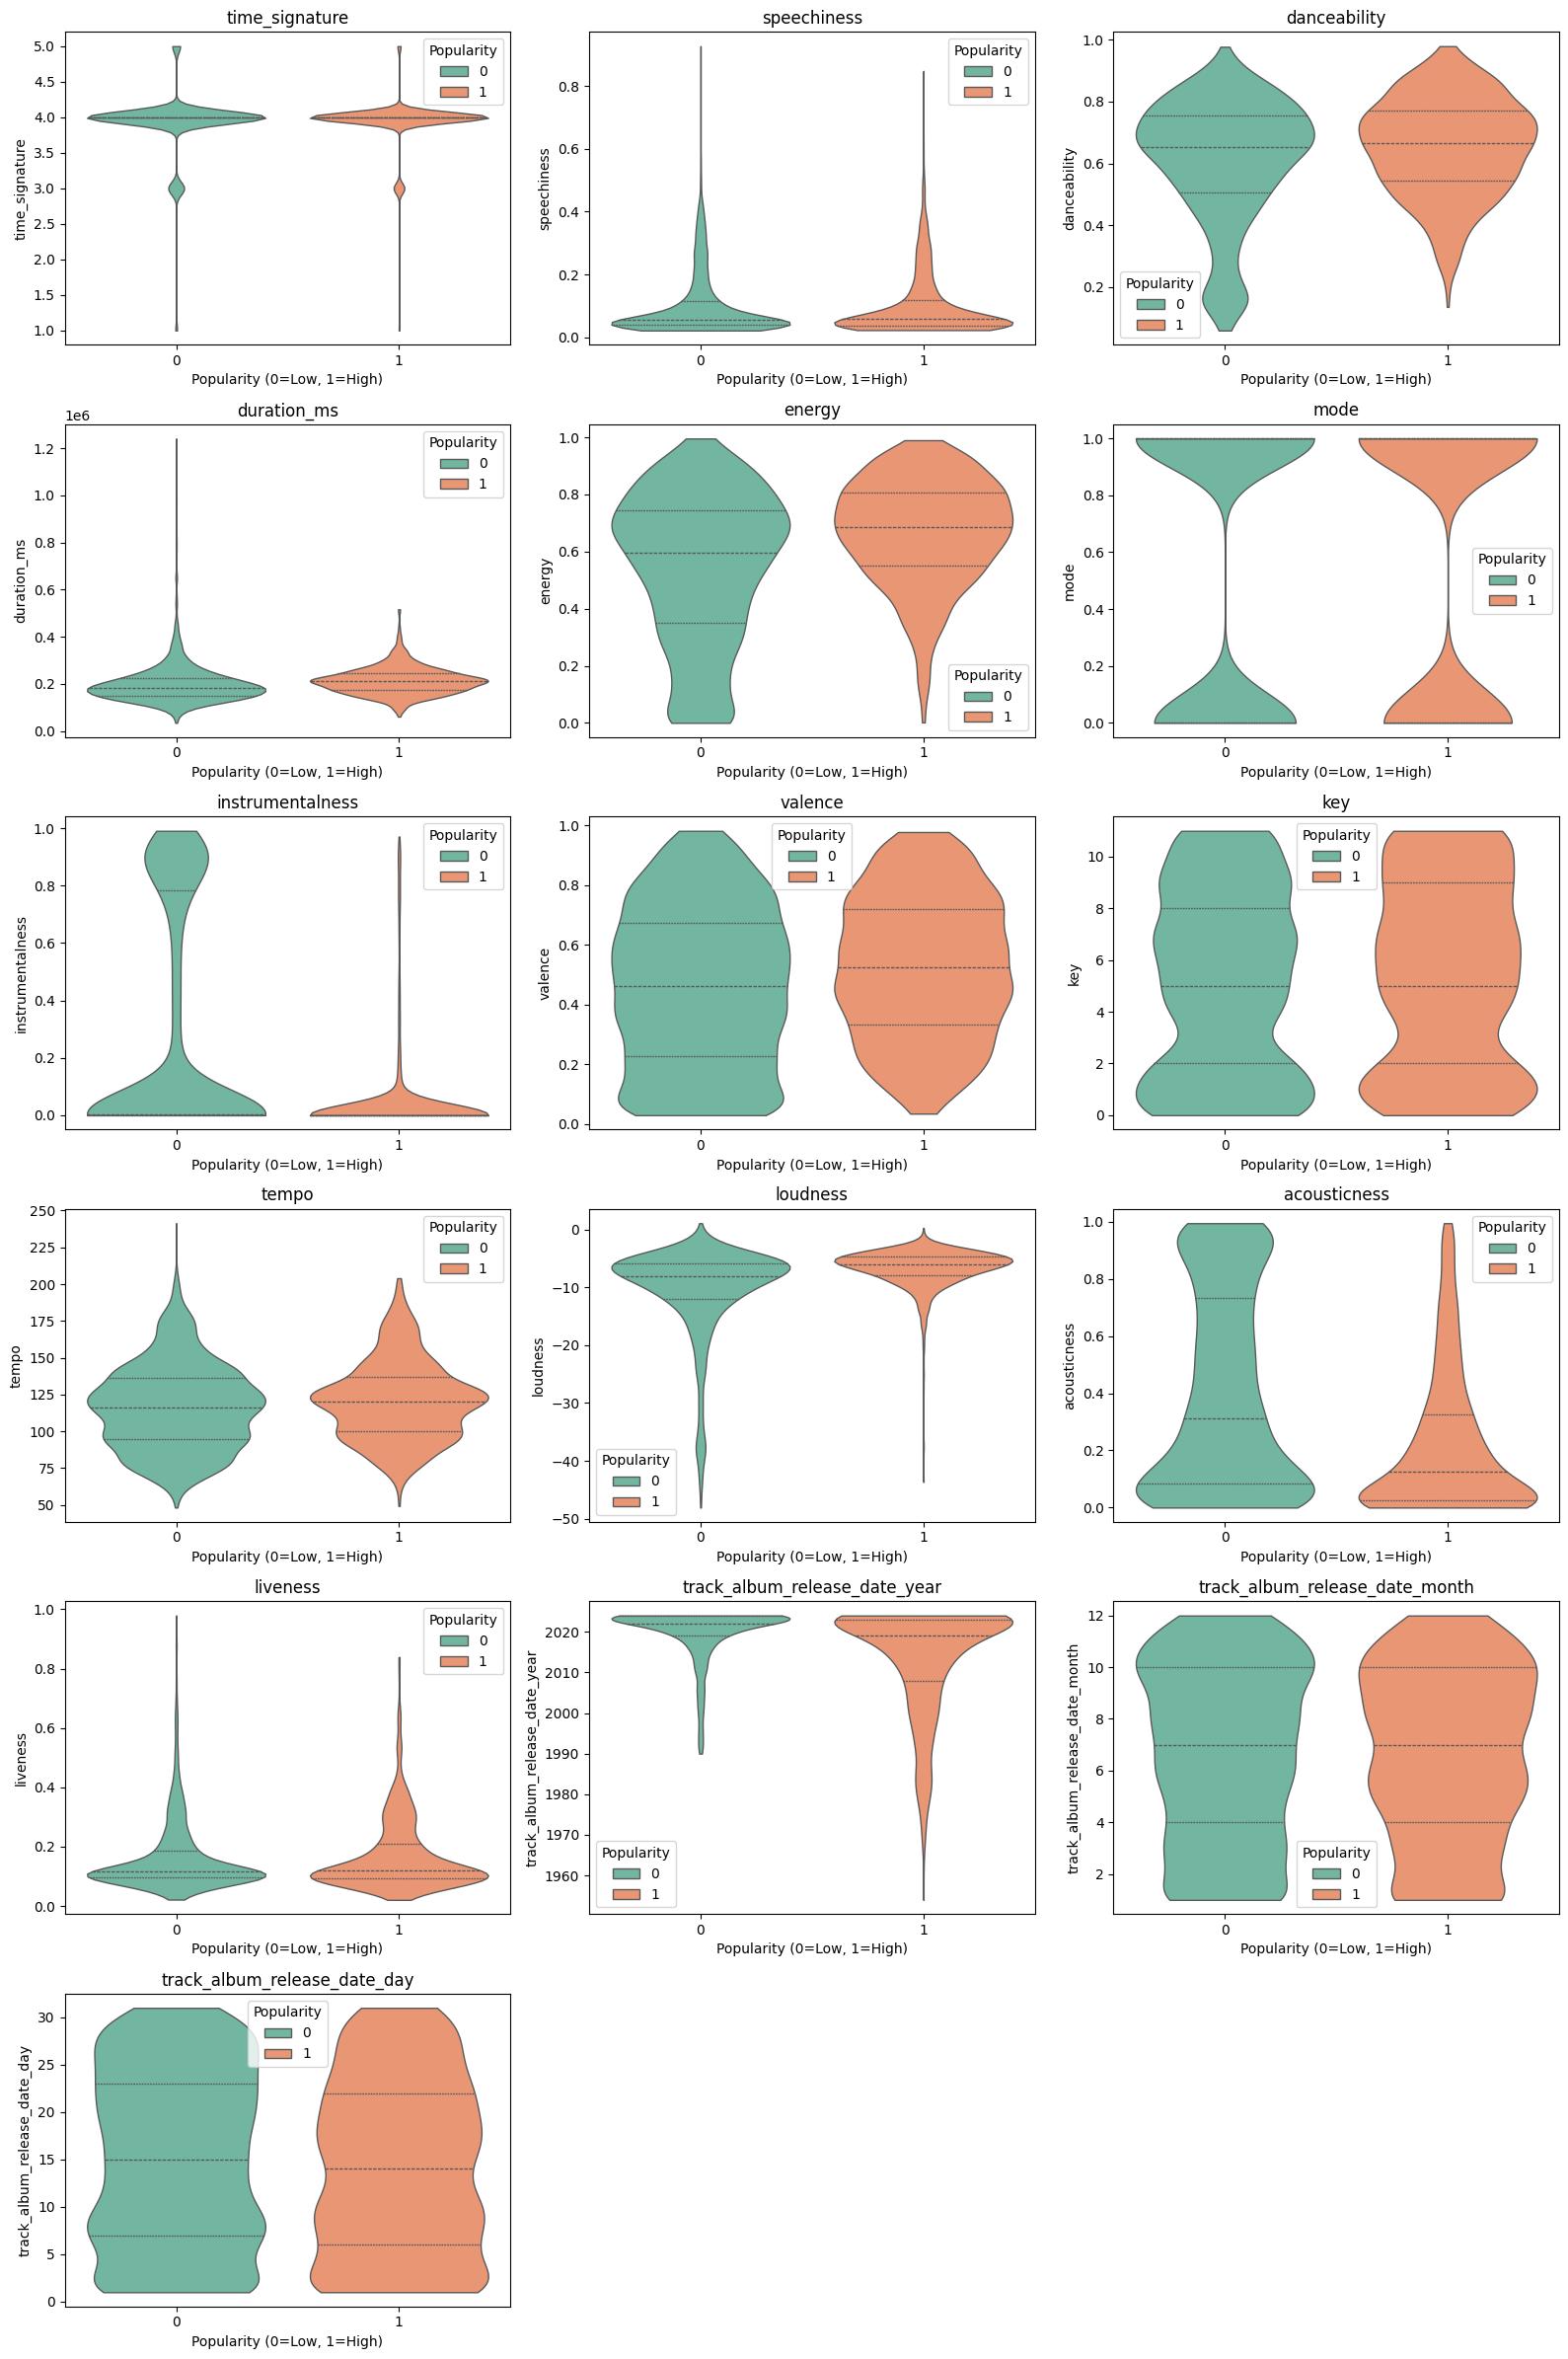

In [18]:
# Violin plots split by label

df = X.copy()
df["Popularity"] = y.astype(int)

num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
print("# numeric cols:", len(num_cols))

# Violin plots, 3 columns layout (similar to your screenshot)
cols = 3
rows = (len(num_cols) + cols - 1) // cols

plt.figure(figsize=(16, 4 * rows))
for i, c in enumerate(num_cols, 1):
    ax = plt.subplot(rows, cols, i)
    sns.violinplot(
        data=df,
        x="Popularity",
        y=c,
        hue="Popularity",
        palette="Set2",
        inner="quartile",   # dashed quartiles like your figure
        cut=0,
        linewidth=1,
        ax=ax,
    )
    ax.set_xlabel("Popularity (0=Low, 1=High)")
    ax.set_title(c)
plt.tight_layout()
plt.show()

From this plot, we discover the following properties related to data labeling:

- Popular songs tend to sound more energetic and upbeat.
They generally have higher danceability, energy, loudness, and valence.

- Low acoustic and instrumental content is strongly linked to popularity.
Most popular songs have very low instrumentalness and acousticness. Less popular tracks show much wider variation in these features.

- Some features matter more than others.
Features like time signature and key look very similar across the two groups and provide limited information.

- Release timing and song length play a smaller role.
Popular songs are slightly more concentrated in recent years and around typical song lengths, but these effects are weaker than those from audio features.

Overall takeaway:
These patterns support using tree-based models like XGBoost, which can naturally capture uneven distributions and sharp cutoffs in features, without heavy feature scaling or transformations.

### 3.4 Correlation heatmap
Before building a model, it is important to understand how features relate to each other. A correlation heatmap helps us spot redundant information, strong linear relationships, and potential interactions.

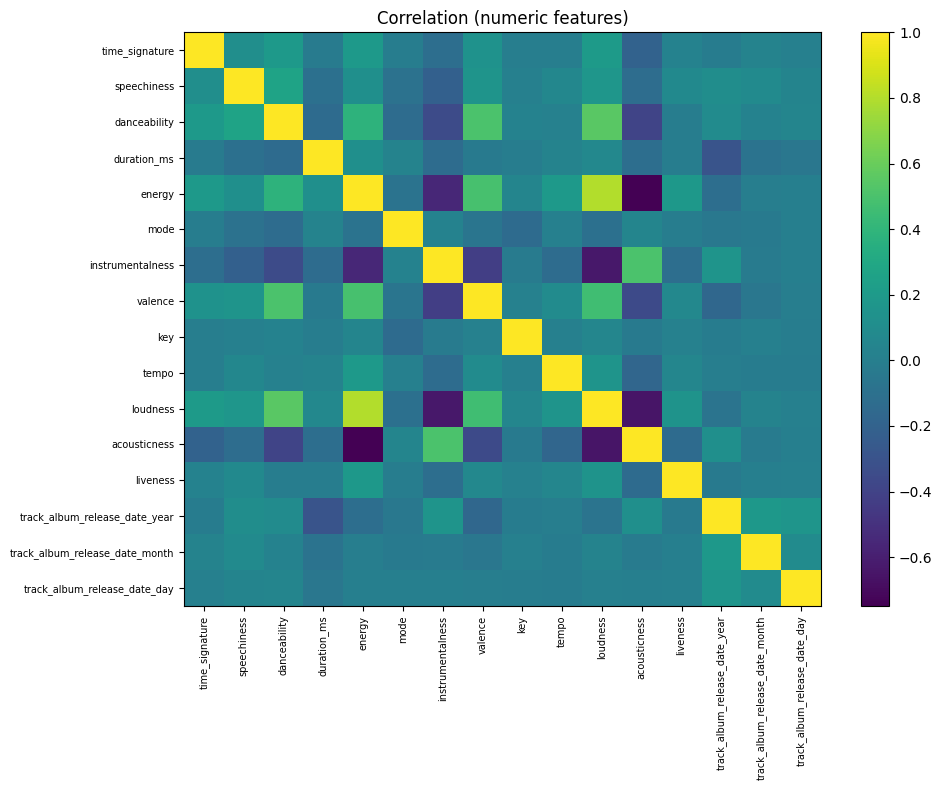

In [14]:
if len(num_cols) > 1:
    corr = X[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(10,8))
    plt.imshow(corr.values, aspect='auto')
    plt.colorbar()
    plt.title("Correlation (numeric features)")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90, fontsize=7)
    plt.yticks(range(len(num_cols)), num_cols, fontsize=7)
    plt.tight_layout()
    plt.show()

This correlation plot helps us understand which features carry similar information and which ones contribute independently.
We see that only a few audio features (such as energy, loudness, and danceability) are strongly correlated while most others are weakly related.
So the dataset is not heavily redundant. This reduces concerns about multicollinearity and suggests that keeping a wide set of features is beneficial.

For training, this supports using tree-based models that can handle correlated features naturally, while also guiding regularization choices to prevent the model from over-emphasizing tightly related variables.

## (4) Feature importance

We plot feature importance to understand which inputs the model actually relies on.
This helps us verify that the model is using meaningful signals.

Below we do a quick XGBoost and one-hot for categorical.

Saved: feature_importance_gain.csv


,feature,gain
6,num__instrumentalness,5.614980
13,num__track_album_release_date_year,3.367172
0,num__time_signature,2.642280
11,num__acousticness,2.169873
10,num__loudness,2.106534
15,num__track_album_release_date_day,1.891666
4,num__energy,1.863348
3,num__duration_ms,1.861449
2,num__danceability,1.804970
7,num__valence,1.794589


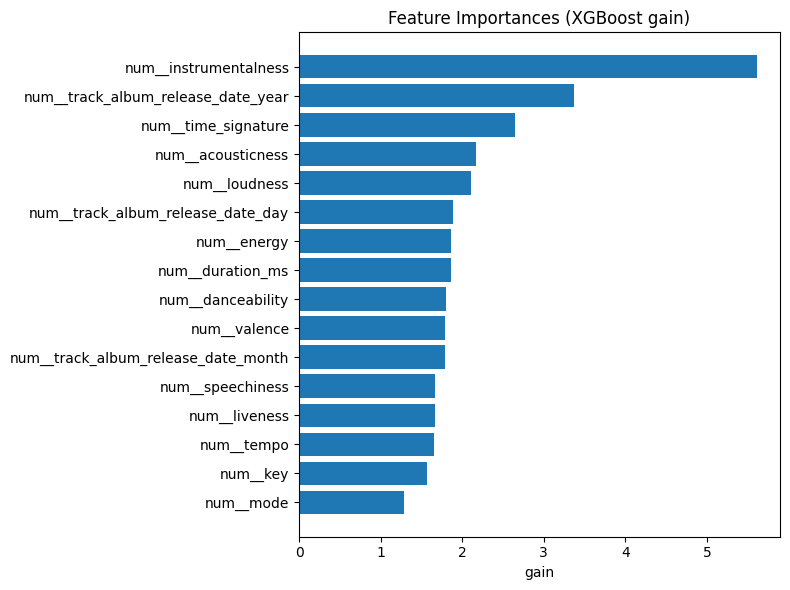

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier

# Split columns by type
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ]), cat_cols),
    ],
    remainder="drop",
)

clf = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,
    gamma=0.1,
    reg_lambda=5.0,
    reg_alpha=0.1,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=0,
    n_jobs=-1,
)

pipe = Pipeline([("pre", pre), ("clf", clf)])
pipe.fit(X, y.astype(int))

# Get feature names after preprocessing
feat_names = pipe.named_steps["pre"].get_feature_names_out()

# Gain-based importance from the fitted booster
booster = pipe.named_steps["clf"].get_booster()
gain = booster.get_score(importance_type="gain")  # keys like "f0", "f1", ...

# Build a clean table: feature_name -> gain
rows = []
for k, v in gain.items():
    idx = int(k[1:])  # "f12" -> 12
    if 0 <= idx < len(feat_names):
        rows.append((feat_names[idx], float(v)))

imp_df = pd.DataFrame(rows, columns=["feature", "gain"]).sort_values("gain", ascending=False)

# Save full importance table (useful for report)
imp_df.to_csv("feature_importance_gain.csv", index=False)
print("Saved: feature_importance_gain.csv")
display(imp_df.head(15))

# Plot top 20
plot_df = imp_df.iloc[::-1]  # reverse for horizontal bar plot
plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature"], plot_df["gain"])
plt.title(f"Feature Importances (XGBoost gain)")
plt.xlabel("gain")
plt.tight_layout()
plt.show()

The plot shows which features the model actually uses to make decisions.

Instrumentalness is the most important feature, matching our earlier plots, we claim it can clearly separates popular and less popular songs.
Release year is also very influential.

Other audio features all help the model in a steady, complementary way. Discrete features such as key and mode matter less but still add useful signal.

This confirms that popularity depends on both musical style and when the song was released, and that XGBoost is well suited to capture these patterns.

## (5) Feature Engineering
We want to do feature transformations to make patterns easier for the model to learn.

In [21]:
# Feature engineering helper

REF_DATE = pd.Timestamp("2026-02-10")

def add_engineered_features(df: pd.DataFrame, ref_date: pd.Timestamp = REF_DATE) -> pd.DataFrame:
    out = df.copy()

    if "duration_ms" in out.columns and "log_duration_ms" not in out.columns:
        out["log_duration_ms"] = np.log1p(out["duration_ms"])

    date_cols = {
        "track_album_release_date_year",
        "track_album_release_date_month",
        "track_album_release_date_day",
    }
    if date_cols.issubset(out.columns) and "days_from_ref" not in out.columns:
        dt = pd.to_datetime(
            dict(
                year=out["track_album_release_date_year"],
                month=out["track_album_release_date_month"],
                day=out["track_album_release_date_day"],
            ),
            errors="coerce",
        )
        out["days_from_ref"] = (ref_date - dt).dt.days

    return out

Engineered features plotted: ['log_duration_ms', 'days_from_ref']


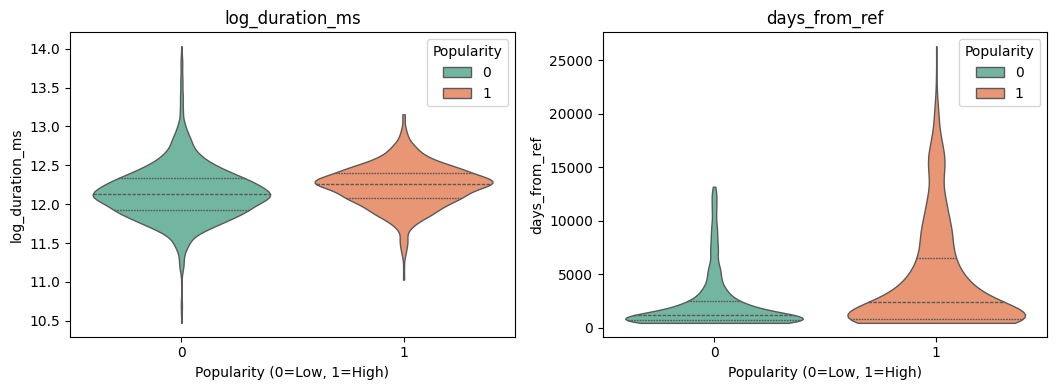

In [22]:
# plot new features
df_fe = add_engineered_features(X)
df_fe["Popularity"] = y.astype(int)

plot_cols = [c for c in ["log_duration_ms", "days_from_ref"] if c in df_fe.columns]
print("Engineered features plotted:", plot_cols)

cols = 3
rows = (len(plot_cols) + cols - 1) // cols

plt.figure(figsize=(16, 4 * rows))
for i, c in enumerate(plot_cols, 1):
    ax = plt.subplot(rows, cols, i)
    sns.violinplot(
        data=df_fe,
        x="Popularity",
        y=c,
        hue="Popularity",
        palette="Set2",
        inner="quartile",
        cut=0,
        linewidth=1,
        ax=ax,
    )
    ax.set_xlabel("Popularity (0=Low, 1=High)")
    ax.set_title(c)

plt.tight_layout()
plt.show()

Taking the log of duration reduces the effect of very long tracks, and converting release dates into “days from a reference date” turns calendar information into a single, meaningful numeric scale that directly captures recency.

We see from the figure that: After the log transform, the distributions of the duration time are tighter and more symmetric.
And the days from reference shows a much cleaner separation.

So these engineered features can better expose useful structure in the data, which helps tree-based models capture the signal more effectively.

## (6) Grid Search

Before getting the final model, we used **grid search** to tune the key hyper-parameters, including the main hyperparameters of both XGBoost and CatBoost, early stopping within each cross-validation fold, and the ensemble weight between the two models.

Searching over these values lets us systematically compare many reasonable configurations instead of relying on manual guesses.

Early stopping per fold helps prevent overfitting by selecting the right model complexity based on validation performance, while still using all training data fairly across folds.
Tuning the ensemble weight allows us to balance the strengths of XGBoost and CatBoost.

Please refer to the last 4 code blocks in this notebook to see our experiment:
https://colab.research.google.com/github/NataliaZhang/SongsClassifier/blob/crqu/notebooks/xgb_search.ipynb

In [28]:
xgb_best_params = {
    "colsample_bytree": 1.0,
    "gamma": 0.8,
    "learning_rate": 0.05,
    "max_depth": 9,
    "min_child_weight": 0.5,
    "n_estimators": 300,
    "reg_alpha": 0.5,
    "reg_lambda": 0.8,
    "subsample": 0.8,
}

cat_best_params = {
    "bagging_temperature": 1.0,
    "depth": 7,
    "iterations": 1000,
    "l2_leaf_reg": 3,
    "learning_rate": 0.03,
    "min_data_in_leaf": 10,
    "subsample": 0.6,
}

weight_xgb = 0.60
weight_cat = 1.0 - weight_xgb

## (7) Final Model
Now we train a final model with XGB and CatBoost on full data, and write the `submission.csv`.

XGBoost captures complex, nonlinear interactions among numeric audio and metadata features, while CatBoost complements it by handling categorical structure and reducing overfitting through ordered boosting.
The two models produce probabilistic predictions that are combined with a weighted average.

In [29]:
# Train final models
from catboost import CatBoostClassifier

if xgb_best_params is None:
    raise ValueError("xgb_best_params is None. Do XGB grid search first.")
if cat_best_params is None:
    raise ValueError("cat_best_params is None. Do CatBoost grid search first.")

# load raw dataset
train_df = _read_csv(paths.data_dir, paths.train_csv)
test_df  = _read_csv(paths.data_dir, paths.test_csv)

if "ID" not in test_df.columns:
    raise ValueError("Expected 'ID' column in test.csv")
if TARGET_COL not in train_df.columns:
    raise ValueError(f"Expected target column '{TARGET_COL}' in train.csv")

# split
y = train_df[TARGET_COL].astype(str).map({"Low": 0, "High": 1})
if y.isna().any():
    raise ValueError(f"Unexpected labels in {TARGET_COL}: {sorted(train_df[TARGET_COL].unique())}")
y = y.astype(int).values

X_raw = train_df.drop(columns=[TARGET_COL])
X_test_raw = test_df.drop(columns=["ID"])

# feature engineering
X_fe = add_engineered_features(X_raw)
X_test_fe = add_engineered_features(X_test_raw)

# one-hot + align columns
X_fe_oh = pd.get_dummies(
    X_fe,
    columns=[c for c in X_fe.columns if X_fe[c].dtype == "object"],
    dummy_na=True,
)
X_test_oh = pd.get_dummies(
    X_test_fe,
    columns=[c for c in X_test_fe.columns if X_test_fe[c].dtype == "object"],
    dummy_na=True,
)

X_test_oh = X_test_oh.reindex(columns=X_fe_oh.columns, fill_value=0)

# fit models
xgb_final = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=0,
    n_jobs=4,
    **xgb_best_params,
)
xgb_final.fit(X_fe_oh, y, verbose=False)

cat_final = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=2000,
    verbose=False,
    **cat_best_params,
)
cat_final.fit(X_fe_oh, y)

# predict and ensemble
p_xgb = xgb_final.predict_proba(X_test_oh)[:, 1]
p_cat = cat_final.predict_proba(X_test_oh)[:, 1]
p_test = weight_xgb * p_xgb + weight_cat * p_cat

if len(p_test) != len(test_df):
    raise ValueError(f"Prediction length {len(p_test)} does not match test rows {len(test_df)}")

# write submission
out_dir = Path(paths.output_dir)
out_dir.mkdir(parents=True, exist_ok=True)
out_file = out_dir / paths.submission_csv

sub = pd.DataFrame({"ID": test_df["ID"], TARGET_COL: p_test})
sub.to_csv(out_file, index=False)
print(f"Wrote: {out_file}")

Wrote: outputs/submission.csv


Our final model reaches a test score of 0.82160.
Here is the strength of this model:
- The features are a mix of skewed, bounded, and discrete values. Gradient-boosted trees naturally handle these patterns without heavy normalization.
- We used feature engineering. Log-transforming duration reduces the impact of extreme values, and converting release dates into a “days from reference” feature captures recency effects more directly.
- Regularization over early stopping is applied. We rely on depth control, subsampling, and L1/L2 penalties to manage overfitting, keeping training simple and stable.
- We use ensembling to improve robustness. XGBoost and CatBoost make different errors. Combining them smooths variance and consistently improves AUC over either model alone.
- We use grid search to tune the hyper-parameters to find the best model.